In [96]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [97]:
nltk.download('stopwords')
import nltk
nltk.download('punkt')
import nltk
nltk.download('wordnet')
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maroua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maroua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maroua\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Maroua\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

The original data contains 147843 examples that we split into train and test datasets as follows :

- The training dataset contains 67% of the original dataset. It is accessible in CSV format in data/train.csv

- The testing dataset contains 33% of the original dataset. It is accessible in CSV format in data/test.csv

In [41]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')


del data_train['Unnamed: 0']
del data_test['Unnamed: 0']

### Data insights

In [42]:
data_train.head()

,name,comment_karma,link_karma,type,body,subreddit,label
0,clovehoney,1580,7,submission,Practically been awake almost 2 days straight ...,Concerta,0
1,leafietheleaf,1411,5340,comment,I think Japanese use wwww and Indonesians use ...,NoStupidQuestions,0
2,laceonajersey,6531,1921,comment,The only thing I would change about what you'v...,lgbt,0
3,onenonly98,17,7,comment,So you took 75ug and now you wanna take 200ug?...,LSD,1
4,0077700,416,1,comment,"Yea, I'm sure there are but you can tell by lo...",funny,1


In [43]:
data_train.shape

(99054, 7)

In [44]:
data_test.head()

,name,comment_karma,link_karma,type,body,subreddit,label
0,namelesspie1,25,12,submission,"Need help with runes : Hey, can somebody tell ...",leagueoflegends,1
1,ryanchoi,119,29,comment,"welp, seems that i didn't get it.",Primedice,1
2,kynrto,14327,12419,comment,"Totally understandable, they are both really good",DanMachi,0
3,purple_dragon_9,38094,10439,submission,(image contains spoiler) this subreddit be lik...,BungouStrayDogs,0
4,bigfeetdonthate,98,840,submission,POTENTIAL TRADING OPPORTUNITY - PrimeCoin ($XP...,primecoin,1


In [45]:
data_test.shape

(48789, 7)

In [46]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99054 entries, 0 to 99053
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           99054 non-null  object
 1   comment_karma  99054 non-null  int64 
 2   link_karma     99054 non-null  int64 
 3   type           99054 non-null  object
 4   body           99053 non-null  object
 5   subreddit      99054 non-null  object
 6   label          99054 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [47]:
data_train.describe()

,comment_karma,link_karma,label
count,9.905400e+04,9.905400e+04,99054.000000
mean,1.085041e+04,7.181353e+03,0.303875
std,5.489147e+04,7.897344e+04,0.459931
min,-1.000000e+02,1.000000e+00,0.000000
25%,3.570000e+02,1.000000e+02,0.000000
50%,1.994000e+03,8.870000e+02,0.000000
75%,8.169000e+03,4.448000e+03,1.000000
max,3.141592e+06,4.841046e+06,1.000000


In [48]:
data_train.describe(include=object)

,name,type,body,subreddit
count,99054,99054,99053,99054
unique,9067,2,96242,14607
top,I_Fuck_Watermelons_,comment,u/savevideo,AskReddit
freq,20,56005,86,2622


As we can see our dataset contains basically two types of data, some columns are int while the others are object.

In the following part we will do some data exploration to understand more the data.

### Data Exploration

We first check if there are any missing values in the dataset

In [49]:
data_train.isna().sum()

name             0
comment_karma    0
link_karma       0
type             0
body             1
subreddit        0
label            0
dtype: int64

In [77]:
data_train = data_train.dropna(axis=0)

Here, we plot the counts of comments and submissions.

comment       56004
submission    43049
Name: type, dtype: int64


<AxesSubplot: >

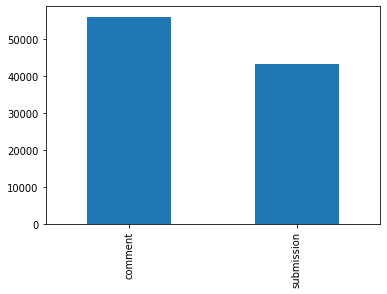

In [79]:
print(data_train.type.value_counts())
data_train.type.value_counts().plot(kind='bar')

And then we plot the count of each label (0,1).

0    68954
1    30099
Name: label, dtype: int64


<AxesSubplot: >

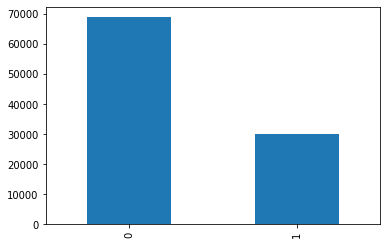

In [80]:
print(data_train.label.value_counts())
data_train.label.value_counts().plot(kind='bar')

In this part we want to detect the language of each body. In order to do that, we should apply some preprocessing on the text (deleting emojis and stopwrods ...)

In [100]:
lemma = WordNetLemmatizer()
stop_words = stopwords.words('english')
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
def text_prep(x):
     corp = str(x).lower() 
     corp = re.sub('[^a-zA-Z]+',' ', corp).strip()
     corp = re.sub('[0-9]+', '', corp)
     corp=remove_emoji(corp)
     tokens = word_tokenize(corp)
     words = [w for w in tokens if len(w) > 2 if not w in stop_words]
     lemmatize = [lemma.lemmatize(w) for w in words]
     l=(' ').join(lemmatize)
     return l

preprocess_tag = [text_prep(i) for i in data_train['body']]
data_train["preprocess_txt"] = preprocess_tag

In [103]:
for i in range(data_train.shape[0]) : 
    languages = []
    text = data_train.preprocess_txt[i] 
    text = remove_emoji(text)
    if len(text) != 0:
        language = detect(text)
        
        languages.append(language)
    else : 
        pass
languages


[Text(0.5, 0, 'comment_karma'),
 Text(1.5, 0, 'link_karma'),
 Text(2.5, 0, 'label')]

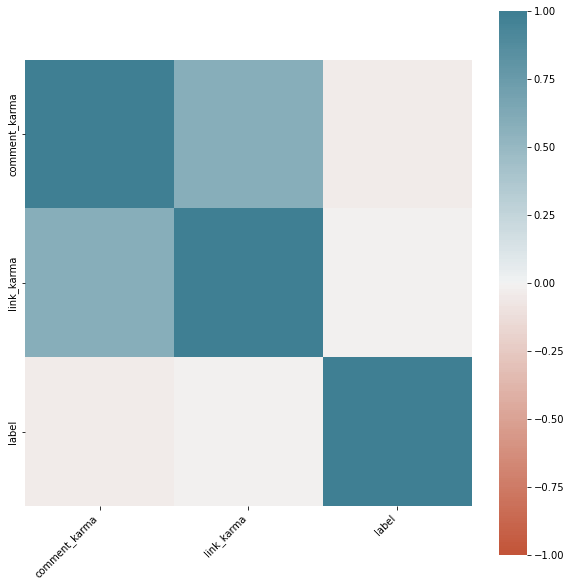

In [53]:
corr = data_train.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)